In [1]:
# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir) 
print("Appended base directory", base_dir)

# Import base libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Import local libraries
from aux.stat.infotheory import binnedRelAreaMulti, binnedEntropyMulti
from aux.stat.surrogate import independentVariableEstimate

Appended base directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis/python/


### Binned entropy test

Question: what is the best model-free way to check if multiple simultaneusly-sampled parameters are completely unrelated to each other?

**Null Hypotesis**: Data was generated from a distribution, which is a product of its marginal 1D probability distributions.

**Strategy**:
1. Get original multidimensional data X
2. Compute marginal empirical CDF for each dimension $i$ from $X_i$
3. Generate surrogate data for dimension independently, same amount as X
4. Compute entropy of data using several bin numbers
5. Compute entropy of surrogate using several bin numbers. Repeat multiple times to get bootstrap variance
6. Plot data entropy vs surrogate entropy
  * For small discretizations, both entropies will be equal to 1 due to coarseness
  * For large discretizations, entropies will be equal due to one data point per bin
  * For middle discretizations, entropy of data should be significantly smaller than surrogate, because it would naturally non-uniformly cover the phase-space.


Finished resample relArea in 8.383914947509766
Finished shuffle relArea in 9.733296394348145
Finished semi-analytic entropy in 2.8766863346099854
Finished resample entropy in 7.756041765213013
Finished shuffle entropy in 9.562699317932129


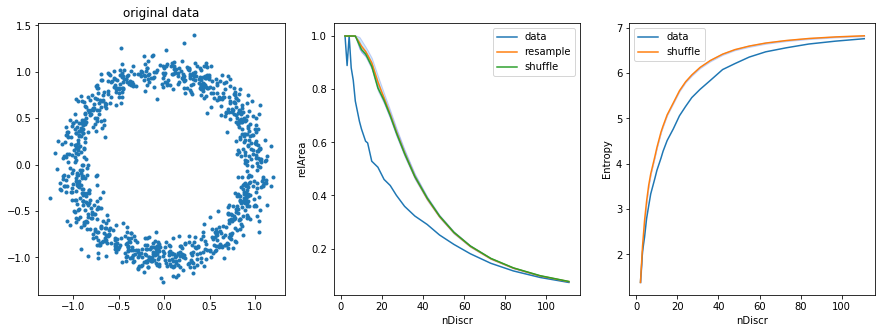

In [2]:
# Create data for noisy circular process
NDATA = 1000
theta = np.random.uniform(0, 1, NDATA)
er = np.random.normal(0, 0.1, NDATA)
x = (1+er)*np.cos(2*np.pi*theta)
y = (1+er)*np.sin(2*np.pi*theta)
# x = np.random.normal(0, 1, NDATA)
# y = np.random.normal(0, 1, NDATA)
data = np.vstack((x, y)).transpose()


# Compute binned entropy for actual data
# nDiscrLst = np.array(list(range(2, 40)))
nDiscrLst = (4**np.arange(0.5, 3.5, 0.1)).astype(int)
realArea = binnedRelAreaMulti(data, nDiscrLst)
realEntr = binnedEntropyMulti(data, nDiscrLst)

N_TRIAL = 100

# Compute relative phase space area for scrambled data
timeStart = time()
surrAreaResample = independentVariableEstimate(data, nDiscrLst, N_TRIAL, binnedRelAreaMulti, "resample")
print("Finished resample relArea in", time()-timeStart)
timeStart = time()
surrAreaShuffle = independentVariableEstimate(data, nDiscrLst, N_TRIAL, binnedRelAreaMulti, "shuffle")
print("Finished shuffle relArea in", time()-timeStart)

# Compute binned entropy for scrambled data
timeStart = time()
surrEntrAnalytic = independentVariableEstimate(data, nDiscrLst, N_TRIAL, binnedEntropyMulti, "semi-analytic")
print("Finished semi-analytic entropy in", time()-timeStart)
timeStart = time()
surrEntrResample = independentVariableEstimate(data, nDiscrLst, N_TRIAL, binnedEntropyMulti, "resample")
print("Finished resample entropy in", time()-timeStart)
timeStart = time()
surrEntrShuffle = independentVariableEstimate(data, nDiscrLst, N_TRIAL, binnedEntropyMulti, "shuffle")
print("Finished shuffle entropy in", time()-timeStart)

# Plot stuff
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(x, y, '.')
ax[0].set_title("original data")

ax[1].set_xlabel("nDiscr")
ax[1].set_ylabel("relArea")
ax[1].plot(nDiscrLst, realArea, label="data")
ax[1].plot(nDiscrLst, surrAreaResample[0], label="resample")
ax[1].plot(nDiscrLst, surrAreaShuffle[0], label="shuffle")
ax[1].fill_between(nDiscrLst,
                surrAreaShuffle[0]-surrAreaShuffle[1],
                surrAreaShuffle[0]+surrAreaShuffle[1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
ax[1].fill_between(nDiscrLst,
                surrAreaResample[0]-surrAreaResample[1],
                surrAreaResample[0]+surrAreaResample[1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
ax[1].legend()

ax[2].set_xlabel("nDiscr")
ax[2].set_ylabel("Entropy")
ax[2].plot(nDiscrLst, realEntr, label="data")
#ax[2].plot(nDiscrLst, surrEntrResample[0], label="resample")
#ax[2].plot(nDiscrLst, surrEntrAnalytic[0], label="semi-analytic")
ax[2].plot(nDiscrLst, surrEntrShuffle[0], label="shuffle")
# ax[2].fill_between(nDiscrLst,
#                 surrEntrAnalytic[0]-surrEntrAnalytic[1],
#                 surrEntrAnalytic[0]+surrEntrAnalytic[1],
#                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#                 antialiased=True)
ax[2].fill_between(nDiscrLst,
                surrEntrShuffle[0]-surrEntrShuffle[1],
                surrEntrShuffle[0]+surrEntrShuffle[1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
# ax[2].fill_between(nDiscrLst,
#                 surrEntrResample[0]-surrEntrResample[1],
#                 surrEntrResample[0]+surrEntrResample[1],
#                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#                 antialiased=True)
ax[2].legend()

plt.show()

Main conclusions:
* **Important!** Semi-analytic surrogate estimate of the maximum entropy of multidimensional data suffers much less from finite data size than the sample entropy or other surrogate estimators, as the probability of having at most 1 data point per bin is exponentially smaller in 1D case than in ND case. Thus, while semi-analytic method is significantly faster than the other methods, it is useless in practice as it is not comparable to sample entropy.
* Resample is slightly faster than shuffle, and the difference between them is negligible.
* Relative area measures more or less the same thing, but is less sensitive to variation of density, unless the density is exactly zero, so entropy is more solid. But perhaps it is also useful?

We can thus plot the generalized mutual information, and see if it is significantly above 0 for most of the values.

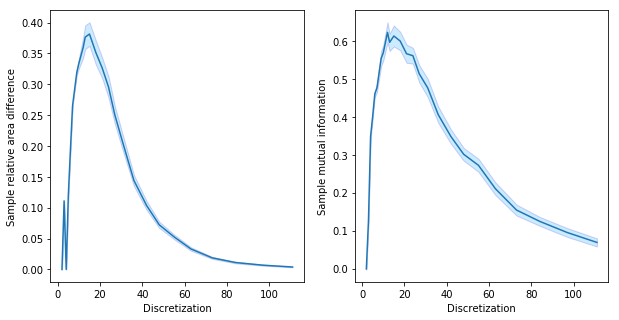

In [4]:
sampleMI = surrEntrResample[0]-realEntr
sampleRAD = surrAreaResample[0]-realArea

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_xlabel("Discretization")
ax[0].set_ylabel("Sample relative area difference")
ax[0].plot(nDiscrLst, sampleRAD)
ax[0].fill_between(nDiscrLst,
                sampleRAD-surrAreaResample[1],
                sampleRAD+surrAreaResample[1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)

ax[1].set_xlabel("Discretization")
ax[1].set_ylabel("Sample mutual information")
ax[1].plot(nDiscrLst, sampleMI)
ax[1].fill_between(nDiscrLst,
                sampleMI-surrEntrResample[1],
                sampleMI+surrEntrResample[1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
plt.show()